In [1]:
!pip install gmft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 17.4 MB/s eta 0:00:00


In [2]:
!pip show gmft

Name: gmft
Version: 0.3.2
Summary: Lightweight, performant, deep table extraction
Home-page: https://github.com/conjuncts/gmft
Author: conjunct, conjuncts
Author-email: 
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, pandas, pillow, pypdfium2, tabulate, torch, transformers
Required-by: 


In [3]:
# get the PubTables-1M paper, source of original Table Transformer (TATR)
!mkdir ./samples
!wget -O ./samples/tatr.pdf -q https://arxiv.org/pdf/2110.00061
!wget -O ./samples/attention.pdf -q https://arxiv.org/pdf/1706.03762
!wget -O ./samples/nmr.pdf -q http://ccc.chem.pitt.edu/wipf/Web/NMR_Impurities.pdf

### setup

In [13]:
from IPython.display import display, HTML
from PIL import Image
import io
import base64

def display_html_and_image(html_content, pil_image):
    # Convert the PIL image to a base64 string to embed it directly in the HTML
    img_buffer = io.BytesIO()
    pil_image.save(img_buffer, format='PNG')  # You can change the format if needed
    img_data = base64.b64encode(img_buffer.getvalue()).decode('utf-8')
    img_base64 = f"data:image/png;base64,{img_data}"

    # HTML content to display the image and HTML side by side
    html = f"""
    <style>
    table, th, td {{
        border: 1px solid #A9A9A9 !important;
        border-collapse: collapse;
    }}
    th, td {{
        padding: 2px !important;
        text-align: left;
    }}
    </style>
    <div style="display: flex; align-items: center;">
        <div style="flex: 1; padding-right: 10px;">
            {html_content}
        </div>
        <div style="flex: 1;">
            <img src="{img_base64}" alt="PIL Image" style="max-width: 100%;"/>
        </div>
    </div>
    """

    # Display the HTML and image
    display(HTML(html))

## tatr.pdf, attention.pdf, and nmr.pdf

In [4]:
import gmft

from gmft.pdf_bindings import PyPDFium2Document
from gmft.auto import CroppedTable, TableDetector

detector = TableDetector()

from gmft.auto import AutoTableFormatter
from gmft.auto import AutoFormatConfig

config = AutoFormatConfig()
config.semantic_spanning_cells = True # [Experimental] better spanning cells
config.enable_multi_header = True # multi-indices
formatter = AutoTableFormatter(config)

def ingest_pdf(pdf_path) -> list[CroppedTable]:
    doc = PyPDFium2Document(pdf_path)

    tables = []
    for page in doc:
        tables += detector.extract(page)
    return tables, doc


preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/76.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

In [6]:
import time
import json
_total_detect_time = 0
_total_detect_num = 0
_total_format_time = 0
_total_format_num = 0

results = []
images = []
dfs = []
for paper in ['tatr.pdf', 'attention.pdf', 'nmr.pdf']:
    start = time.time()
    tables, doc = ingest_pdf('./samples/' + paper)
    num_pages = len(doc)
    end_detect = time.time()
    formatted_tables = []
    for i, table in enumerate(tables):
        ft = formatter.extract(table)
        # with open(f'{paper[:-4]}_{i}.info', 'w') as f:
            # f.write(json.dumps(ft.to_dict()))
        try:
            dfs.append(ft.df())
        except Exception as e:
            print(e)
            dfs.append(None)
        formatted_tables.append(ft)
        # cache images, because closing document will prevent image access
        images.append(ft.image())
    end_format = time.time()


    doc.close()
    results += formatted_tables
    print(f"Paper: {paper}\nDetect time: {end_detect - start:.3f}s for {num_pages} pages")
    print(f"Format time: {end_format - end_detect:.3f}s for {len(tables)} tables\n")
    _total_detect_time += end_detect - start
    _total_detect_num += num_pages
    _total_format_time += end_format - end_detect
    _total_format_num += len(tables)
print(f"Macro: {_total_detect_time/_total_detect_num:.3f} s/page and {_total_format_time/_total_format_num:.3f} s/table.")
print(f"Total: {(_total_detect_time+_total_format_num)/(_total_detect_num)} s/page")

Paper: tatr.pdf
Detect time: 18.686s for 10 pages
Format time: 5.798s for 6 tables

Paper: attention.pdf
Detect time: 21.904s for 15 pages
Format time: 10.223s for 5 tables

Paper: nmr.pdf
Detect time: 18.810s for 9 pages
Format time: 7.524s for 6 tables

Macro: 1.747 s/page and 1.385 s/table.
Total: 2.2470346829470467 s/page


---

### ./samples/tatr.pdf

,,,,,,

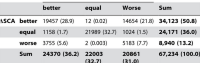

---

,Dataset,Input Modality,# Tables,Cell Topology,Cell Content,Cell Location,Row & Column Location,Canonical Structure
0,TableBank [9],Image,145K,X,,,,
1,SciTSR [3],PDF∗,15K,X,X,,,
2,"PubTabNet [22, 23]",Image,510K‡,X,X,X†,,
3,FinTabNet [22],PDF∗,113K,X,X,X†,,
4,PubTables-1M (ours),PDF∗,948K,X,X,X,X,X

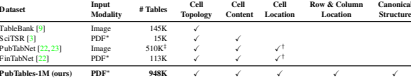

---

,,
0,2:,Split every blank spanning cell into blank grid cells
1,3:,if the first row starts with a blank cell then add the first row to the column header
2,4:,if there is at least one row labeled as part of the column header then
3,5: 6:,while every column in the column header does not have at least one complete cell that only spans that column do: add the next row to the column header end if
4,7:,for each row do: if the row is not in the column header and
5,,has non-blank cell that the first column
6,8:,exactly one occupies then label it a projected row header if any cell in the first column below the column header is
7,,a spanning cell or blank then add the column (below the
8,9:,column header) to the row header MERGE CELLS
9,10:,for each cell in the column header do recursively merge the cell with any adjacent cells above and below in the column

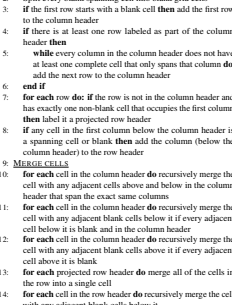

---

Header 2,NaN,NaN,NaN,Tables with an oversegmented PRH,Tables with an oversegmented PRH,Tables with an oversegmented PRH
Header 1,Dataset,Total Tables \nInvestigated†,Total Tables \nwith a PRH∗,Total,% (of total with a PRH),% (of total investigated)
0,SciTSR,"10,431",342,54,15.79%,0.52%
1,PubTabNet,"422,491","100,159","58,747",58.65%,13.90%
2,FinTabNet,"70,028","25,637","25,348",98.87%,36.20%
3,PubTables-1M (ours),"761,262","153,705",0,0%,0%

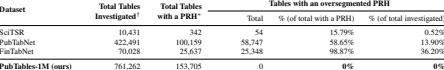

---

,Task,Model,AP,AP50,AP75,AR
0,TD,Faster R-CNN,0.825,0.985,0.927,0.866
1,TD,DETR,0.966,0.995,0.988,0.981
2,TSR + FA,Faster R-CNN,0.722,0.815,0.785,0.762
3,TSR + FA,DETR,0.912,0.971,0.948,0.942

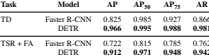

---

,Test Data,Model,Table Category,AccCont,GriTSTop,GriTSCont,GriTSLoc,AdjCont
0,Non-Canonical,DETR-NC,Simple,0.8678,0.9872,0.9859,0.9821,0.9801
1,Non-Canonical,DETR-NC,Complex,0.5360,0.9600,0.9618,0.9444,0.9505
2,Non-Canonical,DETR-NC,All,0.7336,0.9762,0.9761,0.9668,0.9681
3,Canonical,DETR-NC,Simple,0.9349,0.9933,0.9920,0.9900,0.9865
4,Canonical,DETR-NC,Complex,0.2712,0.9257,0.9290,0.9044,0.9162
5,Canonical,DETR-NC,All,0.5851,0.9576,0.9588,0.9449,0.9494
6,Canonical,Faster R-CNN,Simple,0.0867,0.8682,0.8571,0.6869,0.8024
7,Canonical,Faster R-CNN,Complex,0.1193,0.8556,0.8507,0.7518,0.7734
8,Canonical,Faster R-CNN,All,0.1039,0.8616,0.8538,0.7211,0.7871
9,Canonical,DETR,Simple,0.9468,0.9949,0.9938,0.9922,0.9893

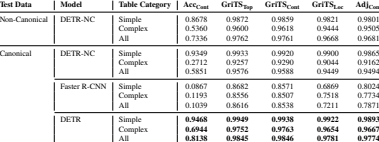

---

---

### ./samples/attention.pdf

,Ashish Vaswani∗ Google Brain avaswani@google.com,Noam Shazeer∗ Google Brain noam@google.com,,Niki Parmar∗ Google Research nikip@google.com,Jakob Uszkoreit∗ Google Research usz@google.com
0,Llion,Aidan N.,Gomez∗ †,Łukasz,Kaiser∗
1,Jones∗ Google Research llion@google.com,University of aidan@cs.toronto.edu,Toronto,,Google Brain lukaszkaiser@google.com
2,,Illia illia.polosukhin@gmail.com,Polosukhin∗ Abstract,,
3,"The dominant sequence convolutional neural performing models mechanism. We based solely on entirely. Experiments be superior in quality less time to train. translation ensembles, by over our model establishes training for 3.5 days best models from the other tasks by applying","transduction networks that include also connect the propose a new simple attention mechanisms, on two machine while being more Our model achieves English￾to-German task, improving 2 BLEU. On the WMT a new single-model on eight GPUs, a literature. We show it successfully to",models are an encoder and network dispensing translation parallelizable 28.4 BLEU over the 2014 state-of-the-art small that the English,"based on complex encoder and a decoder through architecture, the with recurrence and tasks show and requiring on the WMT existing best English-to-French BLEU score fraction of the training Transformer constituency","recurrent or decoder. The best an attention Transformer, convolutions these models to significantly 2014 results, including translation task, of 41.8 after costs of the generalizes well to parsing both with"

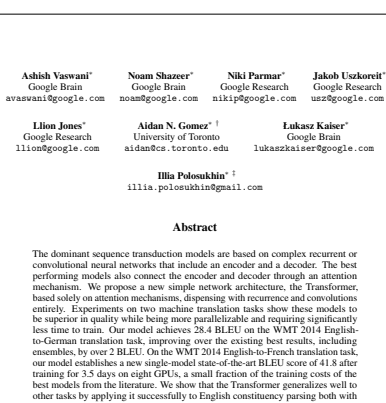

---

,Layer Type,Complexity per Layer,Sequential Operations,Maximum Path Length
0,Self-Attention,O(n 2 · d),O(1),O(1)
1,Recurrent,O(n · d 2 ),O(n),O(n)
2,Convolutional,O(k · n · d 2 ),O(1),O(logk(n))
3,Self-Attention (restricted),O(r · n · d),O(1),O(n/r)

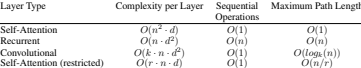

---

Header 2,NaN,BLEU,BLEU,Training Cost (FLOPs),Training Cost (FLOPs)
Header 1,Model,EN-DE,EN-FR,EN-DE,EN-FR
0,ByteNet [18],23.75,,,
1,Deep-Att + PosUnk [39],,39.2,,1.0 · 1020
2,GNMT + RL [38],24.6,39.92,2.3 · 1019,1.4 · 1020
3,ConvS2S [9],25.16,40.46,9.6 · 1018,1.5 · 1020
4,MoE [32],26.03,40.56,2.0 · 1019,1.2 · 1020
5,Deep-Att + PosUnk Ensemble [39],,40.4,,8.0 · 1020
6,GNMT + RL Ensemble [38],26.30,41.16,1.8 · 1020,1.1 · 1021
7,ConvS2S Ensemble [9],26.36,41.29,7.7 · 1019,1.2 · 1021
8,Transformer (base model),27.3,38.1,3.3 ·,1018

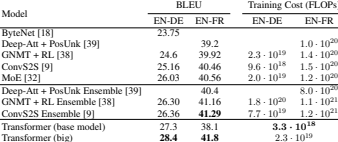

---

,,N,dmodel,dff,h,dk,dv,Pdrop,ϵls,train steps,PPL (dev),BLEU (dev),params ×106
0,base,6,512,2048,8,64,64,0.1,0.1,100K,4.92,25.8,65
1,base,,,,1,512,512,,,,5.29,24.9,
2,base,,,,4,128,128,,,,5.00,25.5,
3,(A),,,,16,32,32,,,,4.91,25.8,
4,(A),,,,32,16,16,,,,5.01,25.4,
5,(A),,,,,16,,,,,5.16,25.1,58
6,(B),,,,,32,,,,,5.01,25.4,60
7,(B),2,,,,,,,,,6.11,23.7,36
8,(B),4,,,,,,,,,5.19,25.3,50
9,(B),8,,,,,,,,,4.88,25.5,80

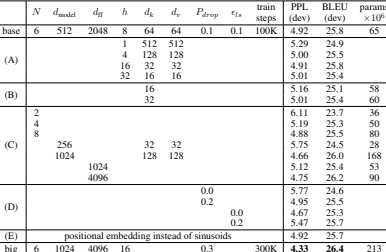

---

,Parser,Training,WSJ 23 F1
0,Vinyals & Kaiser el al. (2014) [37],"WSJ only, discriminative",88.3
1,Petrov et al. (2006) [29],"WSJ only, discriminative",90.4
2,Zhu et al. (2013) [40],"WSJ only, discriminative",90.4
3,Dyer et al. (2016) [8],"WSJ only, discriminative",91.7
4,Transformer (4 layers),"WSJ only, discriminative",91.3
5,Zhu et al. (2013) [40],semi-supervised,91.3
6,Huang & Harper (2009) [14],semi-supervised,91.3
7,McClosky et al. (2006) [26],semi-supervised,92.1
8,Vinyals & Kaiser el al. (2014) [37],semi-supervised,92.1
9,Transformer (4 layers),semi-supervised,92.7

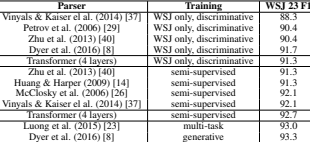

---

---

### ./samples/nmr.pdf

,,
0,"C6D5H in C6D6. E xcept for CHCl3, the splitting due to J HD obser ved (t o a good a ppr oxim ation, it is 1/6.5 of t h e",is t ypically valu e of t
1,"cor r espon din g J HH). F or CHD2 gr ou ps (deut er at ed a cet cet onit rile), t his sign al is a 1:2:3:2:1 quint et wit h a","on e, DMSO, splittin g of ca."


---

,,pr ot on,m ult,CDCl3,(CD3)2CO,(CD3)2SO,C6D6,CD3CN,CD3OD,D2O
0,solvent r esidu al pea k,,,7.26,2.05,2.50,7.16,1.94,3.31,4.79
1,H2O,,s,1.56,2.84a,3.33a,0.40,2.13,4.87,
2,a cetic a cid,CH3,s,2.10,1.96,1.91,1.55,1.96,1.99,2.08
3,a cet on e,CH3,s,2.17,2.09,2.09,1.55,2.08,2.15,2.22
4,a cet onit rile,CH3,s,2.10,2.05,2.07,1.55,1.96,2.03,2.06
5,benzene,CH,s,7.36,7.36,7.37,7.15,7.37,7.33,
6,tert-but yl alcoh ol,CH3,s,1.28,1.18,1.11,1.05,1.16,1.40,1.24
7,tert-but yl alcoh ol,OHc,s,,,4.19,1.55,2.18,,
8,tert-but yl m et h yl et h er,CCH3,s,1.19,1.13,1.11,1.07,1.14,1.15,1.21
9,tert-but yl m et h yl et h er,OCH3,s,3.22,3.13,3.08,3.04,3.13,3.20,3.22

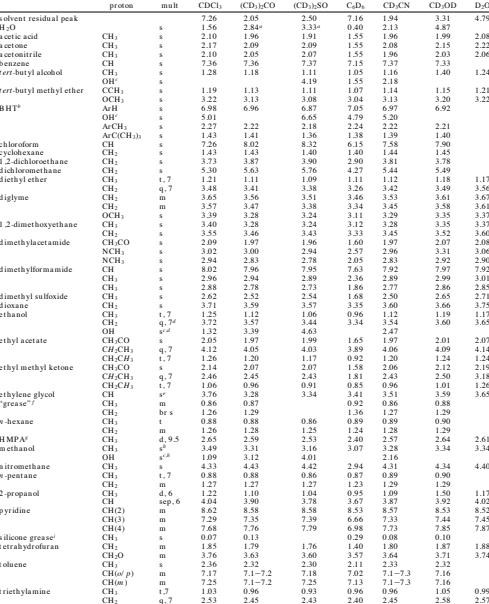

---

,,,CDCl3,(CD3)2CO,(CD3)2SO,C6D6,CD3CN,CD3OD,D2O
0,solvent sign als,,77.16 ( 0.06,29.84 ( 0.01,39.52 ( 0.06,128.06 ( 0.02,1.32 ( 0.02,49.00(0.01,
1,,,,206.26 ( 0.13,,,118.26 ( 0.02,,
2,a cetic a cid,CO,175.99,172.31,171.93,175.82,173.21,175.11,177.21
3,,CH3,20.81,20.51,20.95,20.37,20.73,20.56,21.03
4,a cet on e,CO,207.07,205.87,206.31,204.43,207.43,209.67,215.94
5,,CH3,30.92,30.60,30.56,30.14,30.91,30.67,30.89
6,a cet onit rile,CN,116.43,117.60,117.91,116.02,118.26,118.06,119.68
7,,CH3,1.89,1.12,1.03,0.20,1.79,0.85,1.47
8,benzene,CH,128.37,129.15,128.30,128.62,129.32,129.34,
9,tert-but yl alcoh ol,C,69.15,68.13,66.88,68.19,68.74,69.40,70.36

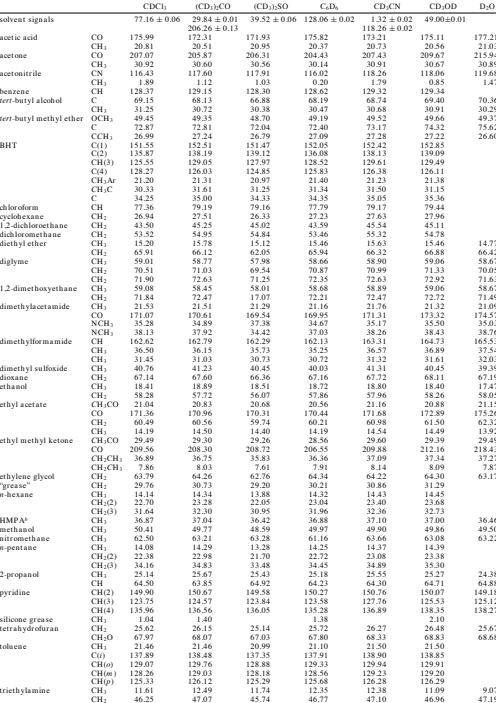

---

,,proton,mult,THF-d8,CD2Cl2 CDCl3,CD2Cl2 CDCl3,toluene-d8,C6D6,C6D6,C6D6,C6D6,C6D6,C6D5Cl,(CD3)2CO,(CD3)2SO,CD3CN,TFE-d3,CD3OD,D2O
0,solvent residual,,,1.72,5.32,7.26,2.08,,,,7.16,,6.96,2.05,2.50,1.94,5.02,3.31,4.79
1,signals,,,3.58,,,6.97,,,,,,6.99,,,,3.88,,
2,,,,,,,7.01,,,,,,7.14,,,,,,
3,,,,,,,7.09,,,,,,,,,,,,
4,water,OH,s,2.46,1.52,1.56,0.43,,,,0.40,,1.03,2.84b,3.33b,2.13,3.66,4.87,
5,acetic acid,CH3,s,1.89,2.06,2.10,1.57,,,,1.52,,1.76,1.96,1.91,1.96,2.06,1.99,2.08
6,acetone,CH3,s,2.05,2.12,2.17,1.57,,,,1.55,,1.77,2.09,2.09,2.08,2.19,2.15,2.22
7,acetonitrile,CH3,s,1.95,1.97,2.10,0.69,,,,0.58,,1.21,2.05,2.07,1.96,1.95,2.03,2.06
8,benzene,CH,s,7.31,7.35,7.36,7.12,,,,7.15,,7.20,7.36,7.37,7.37,7.36,7.33,
9,tert -butyl alcohol,CH3,s,1.15,1.24,1.28,1.03,,,,1.05,,1.12,1.18,1.11,1.16,1.28,1.40,1.24

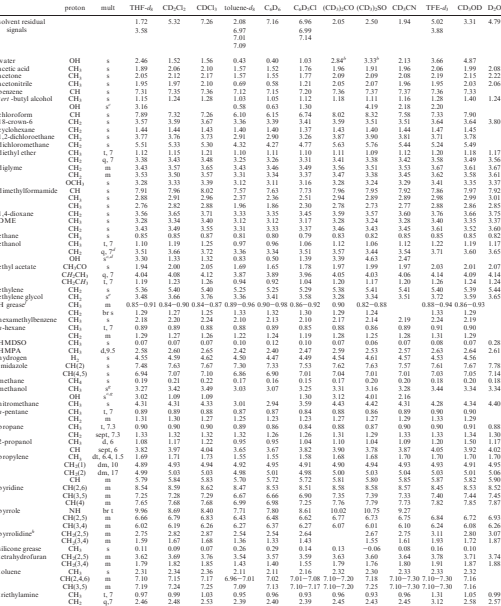

---

,,carbon,THF-d8,CD2Cl2,CDCl3,toluene-,d8 C6D6,,C6D5Cl,(CD3)2CO,(CD3)2SO,CD3CN,TFE-d3,CD3OD,D2O
0,solvent signals,,67.21,53.84,77.16,137.48,128.06,,134.19,29.84,39.52,1.32,61.50,49.00,
1,,,25.31,,,128.87,,,129.26,206.26,,118.26,126.28,,
2,,,,,,127.96,,,128.25,,,,,,
3,,,,,,125.13,,,125.96,,,,,,
4,,,,,,20.43,,,,,,,,,
5,acetic acid,CO,171.69,175.85,175.99,175.30,175.82,,175.67,172.31,171.93,173.21,177.96,175.11,177.21
6,,CH3,20.13,20.91,20.81,20.27,20.37,,20.40,20.51,20.95,20.73,20.91,20.56,21.03
7,acetone,CO,204.19,206.78,207.07,204.00,204.43,,204.83,205.87,206.31,207.43,32.35,209.67,215.94
8,,CH3,30.17,31.00,30.92,30.03,30.14,,30.12,30.60,30.56,30.91,214.98,30.67,30.89
9,acetonitrile,CN,116.79,116.92,116.43,115.76,116.02,,115.93,117.60,117.91,118.26,118.95,118.06,119.68

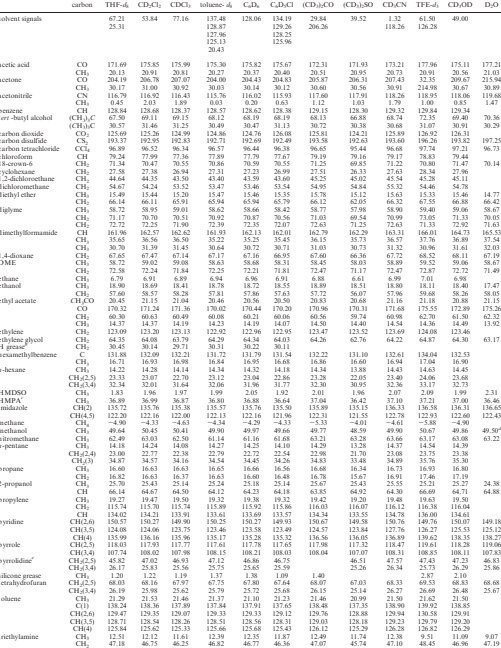

---

,,,,,,,,,,
0,,grateful.,,,,,,,,

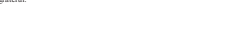

---

In [14]:
from IPython.display import display, Markdown
import pandas as pd

prev_doc = None
for df, img, ft in zip(dfs, images, results):
    with pd.option_context('display.max_rows', 500, "display.multi_sparse", False):
        if ft.page.filename != prev_doc:
            prev_doc = ft.page.filename
            display(Markdown('---'))
            display(Markdown(f'### {ft.page.filename}'))

        if df is not None:
            html = df.fillna("").to_html()
        else:
            html = "Failed to extract table"
        display_html_and_image(html, img)
        display(Markdown('---'))

## bulk extract subset

We will be downloading a bunch of articles to demonstrate bulk extraction. They are all open access articles with permissive licenses. We will be using them unmodified. Many thanks to the respective authors; please see sources in the below table.



| doi                                  | Title                                                                                                                                                     | Author        | Notes                                           | Url                                                                       | License                                                     |
|--------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|---------------|-------------------------------------------------|---------------------------------------------------------------------------|-------------------------------------------------------------|
| 10.1007/s13201-023-02046-6           | Synthesis of a nanocomposite with holocellulose extracted from barley straw and montmorillonite, and optimization of the removal of methylene blue dye using the synthesized adsorbent | Farzi et al.  |                                                 | [Link](https://link.springer.com/content/pdf/10.1007/s13201-023-02046-6.pdf)  | CC BY 4.0   |
| 10.1007/s40268-021-00343-6           | Population Pharmacokinetic Model of N-acetylmannosamine (ManNAc) and N-acetylneuraminic acid (Neu5Ac) in Subjects with GNE Myopathy                          | Wart et al.   |                                                 | [Link](https://link.springer.com/content/pdf/10.1007/s40268-021-00343-6.pdf)  | CC BY 4.0   |
| 10.1038/s41467-023-38544-z           | Approaching enzymatic catalysis with zeolites or how to select one reaction mechanism competing with others                                                | Ferri et al.  | alternating table style                        | [Link](https://www.nature.com/articles/s41467-023-38544-z.pdf)               | CC BY 4.0   |
| 10.1038/srep17787                    | Deciphering Genomic Underpinnings of Quantitative MRI-based Radiomic Phenotypes of Invasive Breast Carcinoma                                               | Zhu et al.    | image table and difficult table with uneven columns | [Link](https://www.nature.com/articles/srep17787.pdf)                        | CC BY 4.0   |
| 10.1107/s2052252519008285            | Catalytically important damage-free structures of a copper nitrite reductase obtained by femtosecond X-ray laser and room-temperature neutron crystallography | Halsted et al. |                                                 | [Link](https://journals.iucr.org/m/issues/2019/04/00/ec5013/ec5013.pdf)      | CC BY 4.0                                                   |
| 10.1186/s12284-023-00656-x           | The Inferior Grain Filling Initiation Promotes the Source Strength of Rice Leaves                                                                          | Jiang et al.  |                                                 | [Link](https://thericejournal.springeropen.com/counter/pdf/10.1186/s12284-023-00656-x.pdf) | CC BY 4.0   |
| 10.1186/1471-2334-11-124             | Core mutations, IL28B polymorphisms and response to peginterferon/ribavirin treatment in Swedish patients with hepatitis C virus genotype 1 infection      | Alestig et al.| very large table                                | [Link](https://bmcinfectdis.biomedcentral.com/counter/pdf/10.1186/1471-2334-11-124.pdf)    | CC BY 2.0                                                   |
| 10.48550/arXiv.2211.13344            | Solubility of water in peridotite liquids and the prevalence of steam atmospheres on rocky planets                                                         | Sossi et al.  | vertical table                                  | [Link](https://arxiv.org/pdf/2211.13344)                                        | CC BY 4.0   |


In [15]:
!mkdir ./bulk
!wget -O bulk/1.pdf bulk -q https://link.springer.com/content/pdf/10.1007/s13201-023-02046-6.pdf
!wget -O bulk/2.pdf bulk -q https://link.springer.com/content/pdf/10.1007/s40268-021-00343-6.pdf
!wget -O bulk/3.pdf bulk -q https://www.nature.com/articles/s41467-023-38544-z.pdf
!wget -O bulk/4.pdf bulk -q https://www.nature.com/articles/srep17787.pdf
!wget -O bulk/5.pdf bulk -q https://journals.iucr.org/m/issues/2019/04/00/ec5013/ec5013.pdf
!wget -O bulk/6.pdf bulk -q https://thericejournal.springeropen.com/counter/pdf/10.1186/s12284-023-00656-x.pdf
!wget -O bulk/7.pdf bulk -q https://bmcinfectdis.biomedcentral.com/counter/pdf/10.1186/1471-2334-11-124.pdf
!wget -O bulk/8.pdf bulk -q https://arxiv.org/pdf/2211.13344

In [16]:
!mkdir results
!mkdir results/false_positives

In [17]:
import json
import re
page_keywords_re_s = [re.compile(x, re.IGNORECASE) for x in \
                    [r'\btables?\b']]

In [18]:
import gmft

from gmft.pdf_bindings import PyPDFium2Document
from gmft.auto import CroppedTable, TableDetector

detector = TableDetector()

from gmft.auto import AutoTableFormatter
from gmft.auto import AutoFormatConfig

config = AutoFormatConfig()
config.semantic_spanning_cells = True # [Experimental] better spanning cells
config.verbosity = 0 # Disable messages
formatter = AutoTableFormatter(config)

def ingest_pdf(pdf_path) -> list[CroppedTable]:
    doc = PyPDFium2Document(pdf_path)

    tables = []
    for page in doc:
        page_text = ""
        for text in page.get_positions_and_text():
            page_text += text[4] + " "
        if any([re.search(x, page_text) for x in page_keywords_re_s]):
            tables += detector.extract(page)
    return tables, doc


In [19]:
import os
from tqdm import tqdm
import traceback

root = "bulk"
save_dir = "results"

last_processed = None # list(os.listdir(root))[4020]

In [20]:
for filename in tqdm(sorted(os.listdir(root))):
    if last_processed is not None and filename < last_processed:
        continue
    if filename.endswith(".pdf"):
        filename = filename[:-4]
        # check if folder exists
        if os.path.exists(f"{save_dir}/{filename}"):
            continue

        # ingest pdf
        doc = None
        try:
            tables, doc = ingest_pdf(f"{root}/{filename}.pdf")
            exists = False
            for i, table in enumerate(tables):
                # check for keywords presence again
                # text = table.text()
                # if not any([re.search(x, text) for x in table_keywords_re_s]):
                    # continue

                if table.label == 1:
                    if not exists:
                        # make folder
                        os.makedirs(f"{save_dir}/{filename}")
                        exists = True
                    table.image(dpi=144).save(f"{save_dir}/{filename}/{i}_rotated.png")
                    json.dump(table.to_dict(), open(f"{save_dir}/{filename}/{i}_rotated.info.json", "w"))
                    continue
                if not exists:
                    # make folder
                    os.makedirs(f"{save_dir}/{filename}")
                    exists = True
                try:
                    ft = formatter.extract(table)
                    # write image, csv, and info to {save_dir}/{filename}/{table_no}.{png,csv,info.json}
                    ft.image(dpi=144).save(f"{save_dir}/{filename}/{i}.png")
                    # with open(f'{paper[:-4]}_{i}.info', 'w') as f:
                    #     f.write(json.dumps(ft.to_dict()))
                    ft.df().to_csv(f"{save_dir}/{filename}/{i}.csv", index=False)
                    # this includes, for instance, outlier info
                    json.dump(ft.to_dict(), open(f"{save_dir}/{filename}/{i}.info.json", "w"))
                except Exception as e:
                    print(f"Error processing {filename}, {i}, {traceback.format_exc()}")
        except Exception as e:
            print(f"Error processing {filename}, {e}")
            continue
        finally:
            if doc is not None:
                doc.close()


        last_processed = filename

100%|██████████| 8/8 [02:06<00:00, 15.87s/it]


(Note that filtering by keywords may speed up inference.)

---

### 1.pdf

,Component,Company
0,Ethanol (96%),Mojallaly (Iran)
1,Sulfuric acid (72%),Mojallaly
2,Acetic acid (98%),Merck
3,Nitric acid (65%),Mojallaly
4,Sodium hydroxide (99%),Merck
5,Montmorillonite,Merck
6,Methylene blue,Mojallaly
7,Urea (99%),Merck

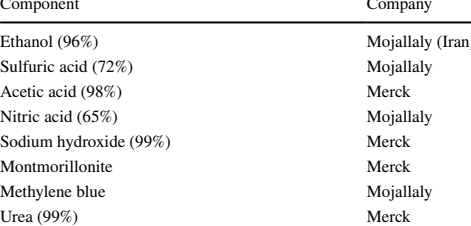

---

,Factor \nComplete name,Factor \nCoded name,Levels \nRange,Levels \n−1,Levels \n0,Levels \n1
0,Temperature (°C),x1,25–35,25,30,35
1,pH,x2,4–8,4,6,8
2,Initial dye concen￾tration (mg L−1),x3,4–8,4,6,8
3,Mesh size,x4,50–150,50,100,150

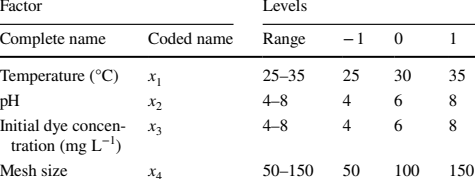

---

,Adsorbent,Specifc surface area (m2 g−1),Total pore vol￾ume (cm3 g−1),Average particle size (nm)
0,HCMM,25.147,8.635,84.172

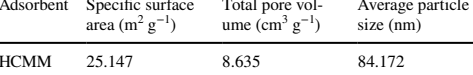

---

,Run,x1: T (°C),x2: pH,x3: MB initial concen￾tration (mg L−1),x4: Mesh size,MB removal (%)
0,1,25,8,4,150,84.90
1,2,30,6,6,100,89.31
2,3,30,6,4,100,90.71
3,4,30,6,6,50,91.09
4,5,30,6,6,100,89.34
5,6,25,8,8,50,87.38
6,7,30,8,6,100,92.12
7,8,30,4,6,100,87.16
8,9,35,8,4,50,92.14
9,10,35,4,8,50,85.56

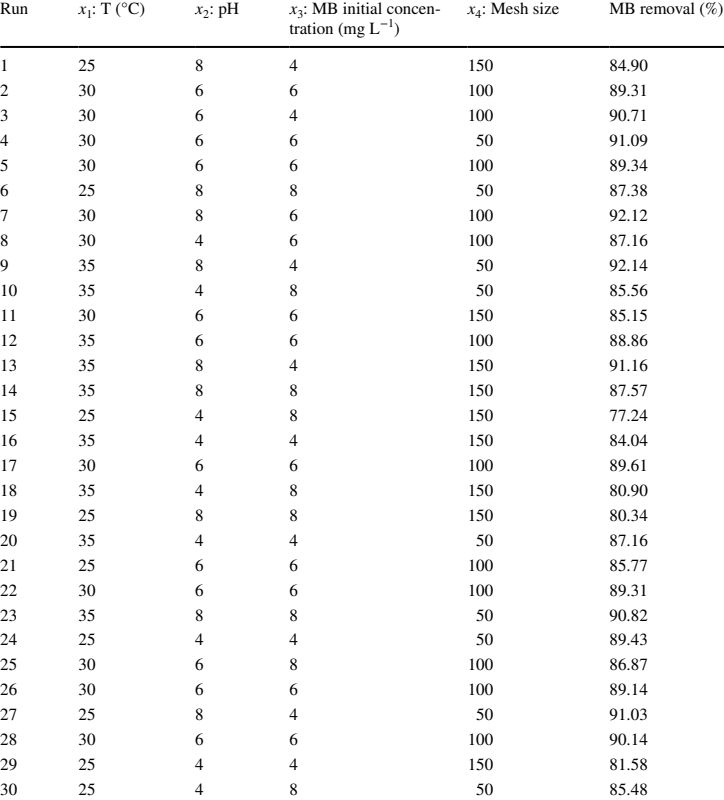

---

<ipython-input-27-8b660cb6aec7>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("",inplace=True)


,Source,DF,Adjusted SS,Adj MS,F value,p value
0,Model,14,401.025,28.6446,218.33,0.0
1,x1,1,6.457,6.4568,49.21,0.0
2,x2,1,2.068,2.068,15.76,0.001
3,x3,1,0.014,0.0141,0.11,0.748
4,x4,1,2.209,2.209,16.84,0.001
5,x2 1,1,10.26,10.2603,78.2,0.0
6,x2 2,1,0.291,0.2908,2.22,0.157
7,x2 3,1,0.687,0.6872,5.24,0.037
8,x2 4,1,3.638,3.6382,27.73,0.0
9,x1x2,1,12.443,12.4433,94.84,0.0

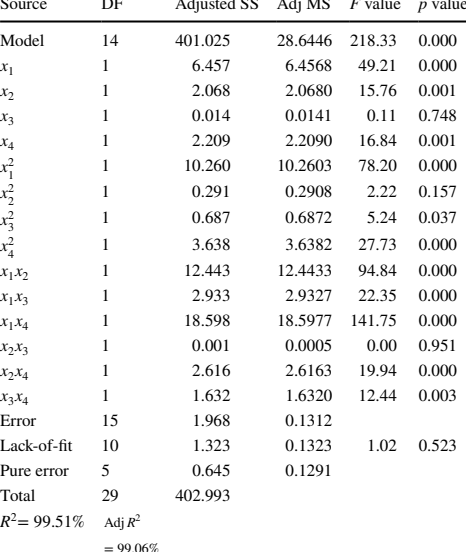

---

,Adsorbent(s),Adsorbent dosage (g/L),Removal percentage,Reference
0,HCMM,1,77.24–95.14,This work
1,Activated carbon from Rumex abyssinicus plant,0.2–0.6,82.16–99.96,Fito et al. (2023)
2,Barley straw and corn stalks modifed by citric acid,6–14,48–97,Soldatkina & Yanar (2023)
3,Activated carbon from Scrap Tire,2.5,89.18–90.48,Kassahun et al. (2022)
4,Barley Bran and Enset Midrib Leaf,2.5,96–98,Mekuria et al. (2022)
5,Raspberry (Rubus idaeus) leaves powder,1–5,30–44,Mosoarca et al. (2022)
6,Activated carbon from grape leaves waste,0.25–12.25,0–97.4,Mousavi et al. (2022a)
7,Activated carbon from grape wood wastes,0.25–12.25,0–95.66,Mousavi et al. (2022b)
8,Black tea wastes,13.3,30–72,Ullah et al. (2022)
9,Carboxymethyl cellulose grafted by polyacrylic acid and decorated with graphene oxide,100,38–97,Hosseini et al. (2022)

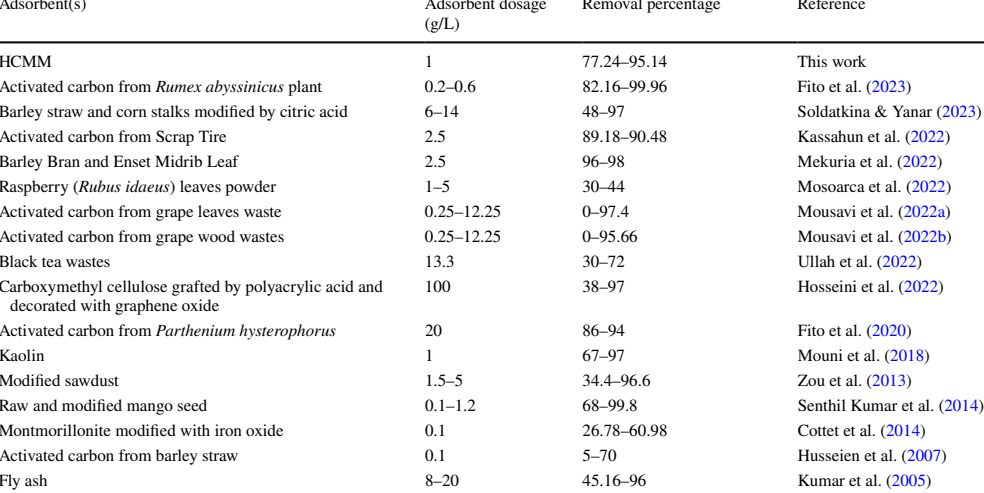

---

,Variable,Optimum value
0,Initial concentration of dye (mg L−1),4.00
1,Temperature (°C),32.00
2,pH,8.00
3,Adsorbent mesh size,70.00
4,Predicted removal percentage,93.91
5,Experimental removal percentage at optimal condi￾tions,95.14

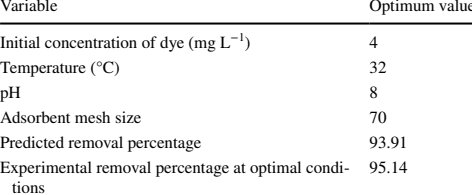

---

,Model,Parameters,Unnamed: 2
0,Langmuir,qm(mg g−1),159
1,Langmuir,kL(L mg−1),0.0956
2,Langmuir,R2,0.984
3,Freundlich,n,2.52
4,Freundlich,kF(mg g−1),26.42
5,Freundlich,R2,0.891
6,Temkin,B,29.245
7,Temkin,kT(L mg−1),1.518
8,Temkin,b(J g mg−1 mol−1),87
9,Temkin,R2,0.970

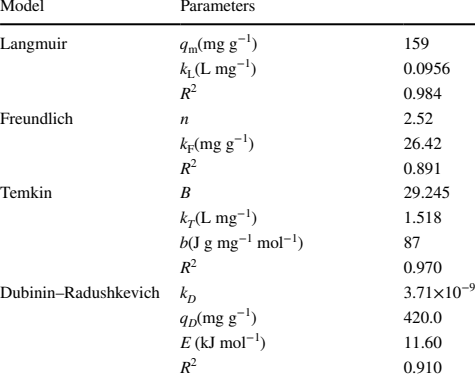

---

,Kinetic model,Parameters,Parameters.1
0,Linear driving force,k1(min−1),0.0604
1,Linear driving force,"qe,calc(mg g−1)",22.3900
2,Linear driving force,"qe,exp(mg g−1)",54.2800
3,Linear driving force,R2,0.9270
4,Pseudo-second-order,"qe,calc(mg g−1)",55.5700
5,Pseudo-second-order,k2(g.mg−1 min−1),0.0180
6,Pseudo-second-order,R2,0.9990
7,Intra-particle difusion,"k3,1(mg g−1 min−0.5)",1.7660
8,Intra-particle difusion,I1(mg g−1),39.3600
9,Intra-particle difusion,R2 1,0.9920

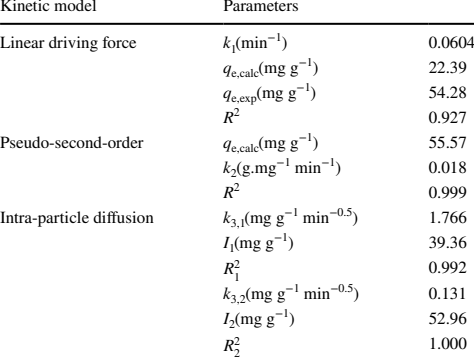

---

---

### 2.pdf

,Stage of phar￾macokinetic modeling,Data utilized,Modeling activities
0,Stage 1,ManNAc single dose pharmacokinetic data (Study 12-HG￾0207),Design of structural pharmacokinetic model Explore absorption models
1,Stage 2,ManNAc BID pharmacokinetic data (Study 15-HG-0068),Covariate analysis Determination of non-linear and stationary pharmacokinetic
2,Stage 3,Stage 2 population pharmacokinetic model for ManNAc and Neu5Ac,Monte Carlo simulations of dosing regimens Recommendation for evaluation of additional TID dosing regimens in an extension of Study 15-HG-0068
3,Stage 4,"All available data, including the additional TID dosing phar￾macokinetic data generated during extension conducted in same patients from Study 15-HG-0068",Finalize pharmacokinetic model

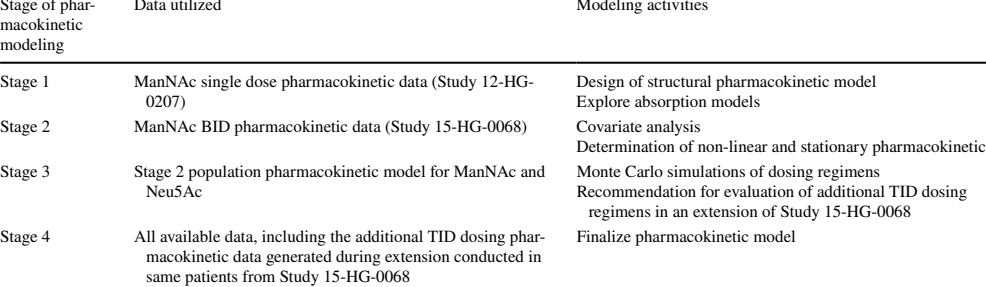

---

<ipython-input-27-8b660cb6aec7>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("",inplace=True)


,Variable,N (%),Mean,SD,Median,Min,Max
0,Age (years),34,41.3,10.4,39.5,25.0,65.0
1,Weight (kg),34,83.5,20.2,84.6,49.3,115.0
2,Height (cm),34,173.0,13.3,172.0,151.0,197.0
3,BMI (kg/m2 ),34,27.6,4.7,27.2,19.1,39.8
4,BSA (m2 ),34,2.01,0.31,2.06,1.45,2.5
5,eGFR (mL/min)a,34,123.0,22.2,120.0,85.0,170.0
6,Albumin (g/dL),34,3.83,0.403,3.8,3.2,4.8
7,Serum creatinine (mg/dL),34,0.499,0.223,0.49,0.12,0.95
8,Creatine kinase (U/L),34,236.0,124.0,220.0,44.0,556.0
9,Sex,,,,,,

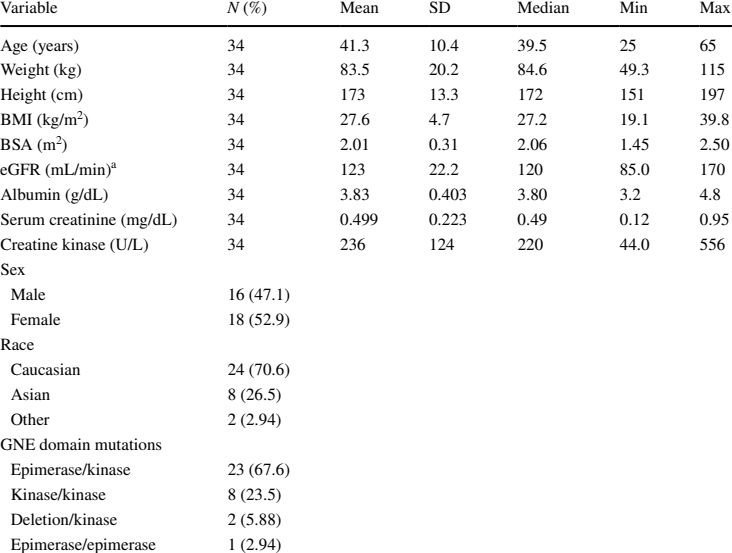

---

<ipython-input-27-8b660cb6aec7>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("",inplace=True)


,ManNAc dose,Q8H for 30 days \nMedian,Q8H for 30 days \n5th–95th percentiles,Q12H for 30 days \nMedian,Q12H for 30 days \n5th–95th percentiles,Q24H for 30 days \nMedian,Q24H for 30 days \n5th–95th percentiles
0,Plasma ManNAc,"Css,ave (ng/mL)",,,,,
1,3 g,922,501–1550,642.0,359–1060,365.0,223–570
2,4 g,1060,573–1790,729.0,404–1220,411.0,246–650
3,6 g,1290,692–2180,881.0,480–1480,483.0,281–780
4,10 g,1650,883–2810,1120.0,607–1900,603.0,340–989
5,Plasma Neu5Ac,"Css,ave (ng/mL)",,,,,
6,3 g,633,247–2010,484.0,209–1420,338.0,174–825
7,4 g,702,265–2300,533.0,222–1610,364.0,181–921
8,6 g,818,296–2780,612.0,242–1930,405.0,190–1080
9,10 g,1020,344–3540,735.0,274–2440,464.0,204–1330

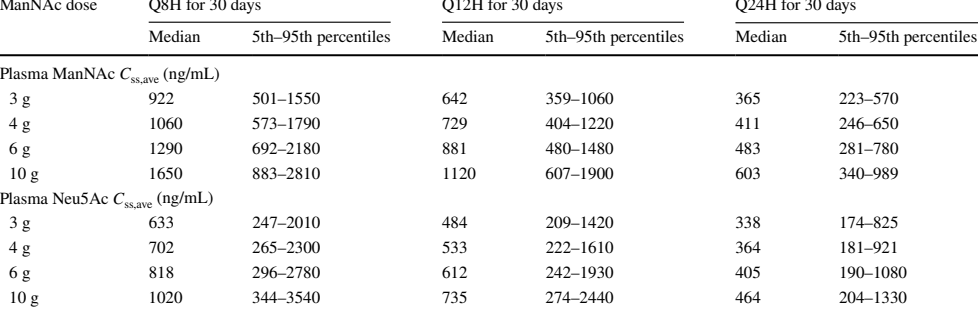

---

,Parameter,Final typical value estimate,%SEM
0,ka (h−1),0.256,15.2
1,CLM/F (L/h),631,14.8
2,VM/F (L),506,29.4
3,M0 (ng/mL),61.1,12.0
4,N0 (ng/mL),150,5.71
5,kout (h−1),0.283,5.65
6,SLP0 (ng/mL)−1,0.000619,29.1
7,SLPSS (ng/mL)−1,0.00334,35.0
8,kinc (h−1),0.0287,45.3
9,tlag (h),0.254,26.4

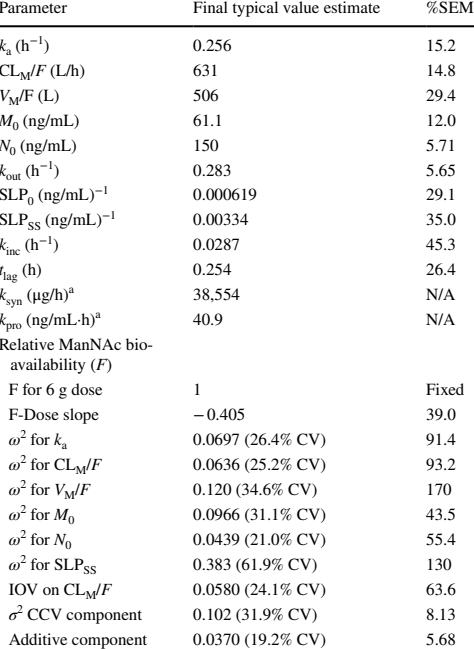

---

---

### 3.pdf

,Unnamed: 0,Channels system,n,Itrans (kJ/mol),Idisp (kJ/mol),Idisp /Itrans
0,BEA,12 × 12 × 12,3,−148,−129,0.87
1,BEC,12 × 12 × 12,1,−123,−151,1.22
2,BOG,12 × 10 × 10,4,−140,−140,1.00
3,CON,12 × 10 × 10,2,−132,−149,1.14
4,FAU,12 × 12 × 12,7,−104,−106,1.02
5,ITT,18 × 10 × 10,4,−110,−155,1.41
6,IWR,12 × 10 × 10,1,−145,−174,1.20
7,IWV,12 × 12,2,−102,−90,0.88
8,MOR,12 × 8,2,−141,−104,0.74
9,SEW,12 × 10,2,−160,−188,1.18

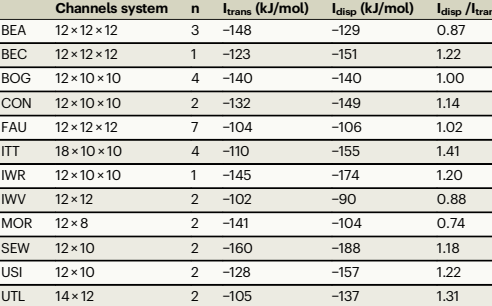

---

<ipython-input-27-8b660cb6aec7>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("",inplace=True)


,Unnamed: 0,Channels system,Ea1,Ea2,Ea3,Ea4,Ea5,Ea6
0,transalkylation,,,,,,,
1,BEC,12 × 12 × 12,98.0,35.0,44.0,48.0,85.0,98.0
2,BOG,12 × 10 × 10,75.0,29.0,65.0,50.0,88.0,96.0
3,IWR,12 × 10 × 10,71.0,31.0,60.0,44.0,91.0,90.0
4,IWV,12 × 12,56.0,21.0,52.0,47.0,60.0,86.0
5,MOR,12 × 8,95.0,33.0,78.0,50.0,84.0,87.0
6,UTL(int),14 × 12,59.0,29.0,49.0,49.0,82.0,97.0
7,UTL(cha),14 × 12,64.0,28.0,57.0,45.0,68.0,80.0
8,disproportionation,,,,,,,
9,BEC,12 × 12 × 12,113.0,30.0,56.0,55.0,78.0,118.0

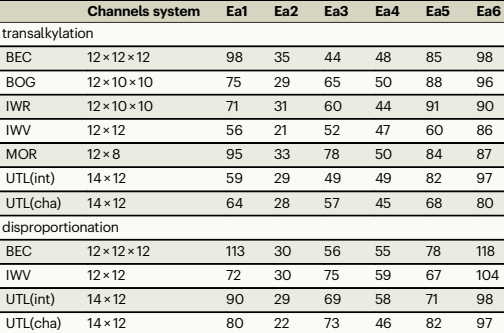

---

,zeolite,IZA code,DEB conv. (%),rtrans (molEB/molacidh),EB (%),TEB (%),C2H4 (%),HP (%),Eaa (kJ/mol)
0,ITQ-33,ITT,11.9,717,76.4,20.8,0.6,2.1,75.2
1,ITQ-15,UTL,17.7,1599,85.7,12.0,0.0,2.3,56.1
2,USY,FAU,14.7,1075,90.1,2.7,2.7,4.5,66.5
3,ITQ-17,BEC,20.8,628,88.8,8.3,0.5,2.3,59.5
4,ITQ-27,IWV,14.9,1926,94.1,0.5,2.3,3.0,58.3
5,ITQ-24,IWR,15.2,676,95.1,2.5,0.4,2.0,69.4
6,ITQ-47,BOG,14.4,349,90.4,4.4,4.8,0.4,66.2
7,mordenite,MOR,9.6,279,88.6,2.5,4.6,4.2,74.2

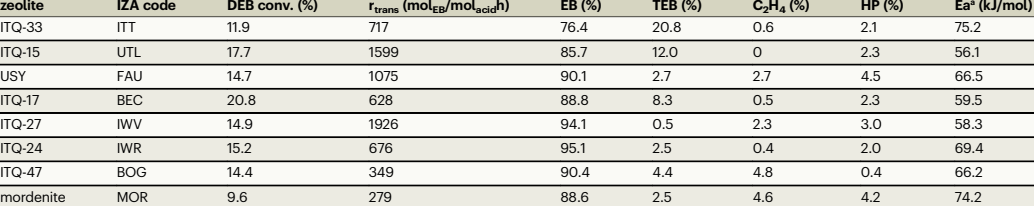

---

---

### 4.pdf

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6

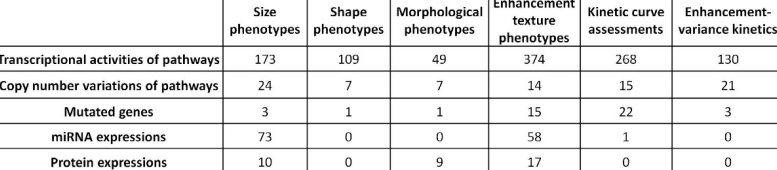

---

,Data Platform,Number of Features,Number of Features.1,Number of Features.2,Number of tumors
0,Number of features and tumors,in different data,platforms,,
1,Radiomics,,38,,91
2,Gene expressions,20531,genes (186,pathways),91
3,Copy number variations,19950,genes (186,pathways),91
4,miRNA expressions,,1046,,91
5,Protein expressions,,142,,62
6,Mutated genes,,3734,,91
7,Number of tumors with different,pathological,stages,,
8,Pathological Stage,T,M,N,Overall
9,0,,91,46,

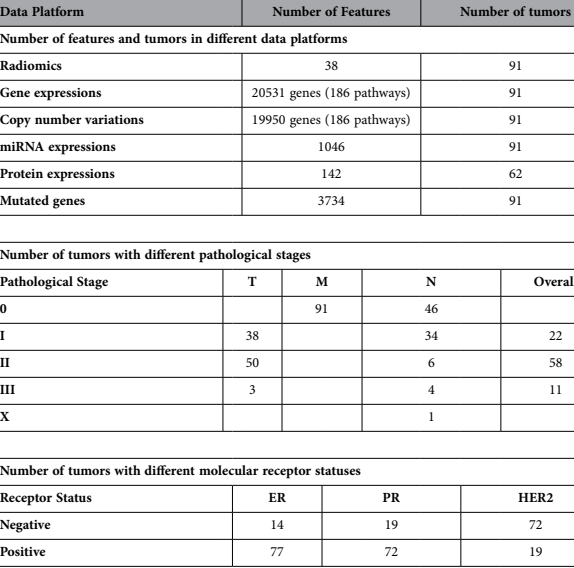

---

---

### 5.pdf

,Unnamed: 0,SF-ROXOX,SF-ROXNIT,SF-ROXRED
0,No. of crystals,75,62,33
1,Images collected,1867,1257,581
2,Images merged,1377,1039,410
3,Data collection,,,
4,Space group,P213,P213,P213
5,a = b = c (A˚ ),94.95,94.92,94.61
6, =  =  ( ),90,90,90
7,Resolution (A˚ ),54.82–1.50,54.80–1.50,54.62–1.60
8,,(1.54–1.50),(1.54–1.50),(1.64–1.60)
9,Rsplit† (%),11.5 (90.4),10.6 (85.3),15.8 (70.8)

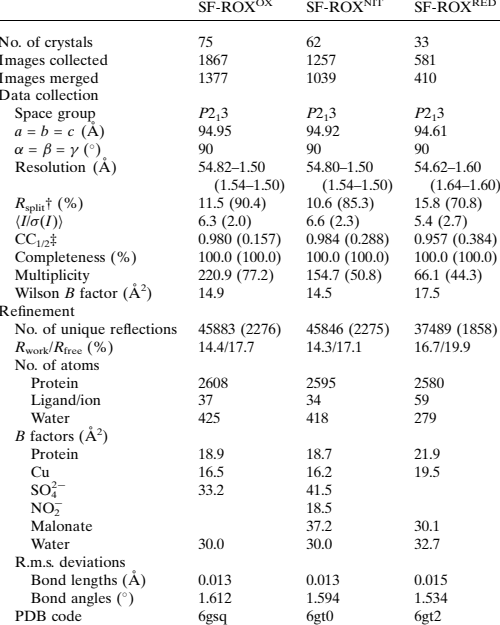

---

,Unnamed: 0,Unnamed: 1
0,Data collection,
1,Wavelength range (A˚ ),3.05–4.00
2,No. of images,20
3,Setting spacing (),7
4,Average exposure time (h),18
5,Space group,P213
6,a = b = c (A˚ ),97.98
7, =  =  ( ),90
8,Resolution (A˚ ),40–1.80 (1.90–1.80)
9,Rp.i.m. (%),6.3 (12.7)

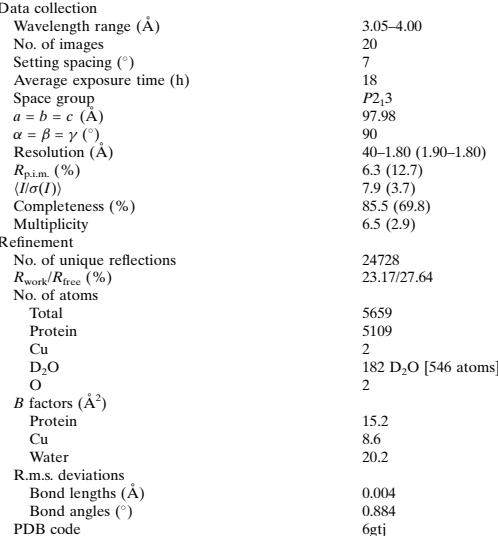

---

---

### 6.pdf

,Year,Variety,Treatment,Spikelets per panicle,1000-grain weight (g),Seed setting rate (%),Seed setting rate (%).1
0,2019,CJ03,T0,267.67a,21.87c,87.67c,
1,2019,,T1,91.17b,20.10d,93.00b,
2,2019,W1844,T0,275.67a,22.91b,84.92d,
3,2019,,T1,97.92b,25.95a,95.58a,
4,2020,CJ03,T0,259.75a,22.38c,92.25b,
5,2020,,T1,77.50c,20.97d,94.17a,
6,2020,W1844,T0,273.67a,24.35b,85.17c,
7,2020,,T1,92.58b,25.19a,94.67a,
8,Year,Variety,Treatment,SG per panicle,IG per panicle,SG rate (%),IG rate (%)
9,2019,CJ03,T0,104.65a,163.02b,39.10a,60.90b

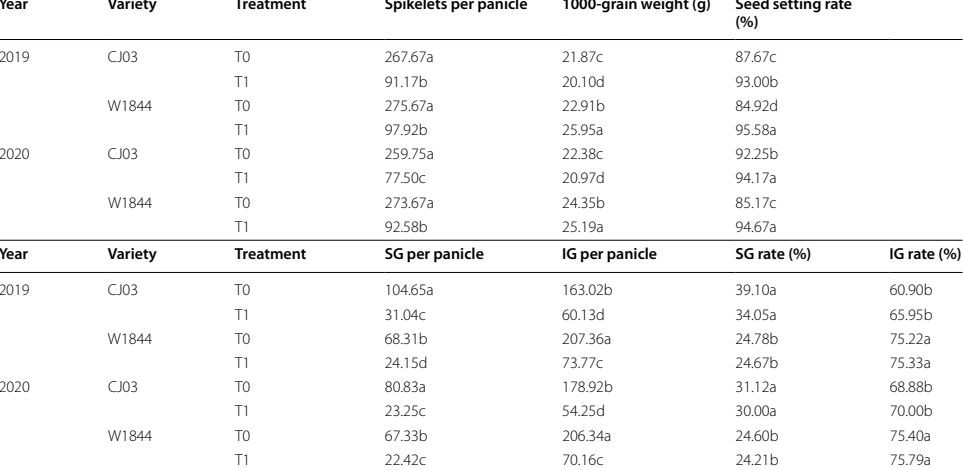

---

,Year,Variety,Treatment,Net photosynthetic rate (umol·m−2 s−1 ),Stomatal conductance (mmol·m−2 s−1 ),Intercellular CO2 concentration (μmol·mol−1 ),Trmmol rate (mmol·m−2 s−1 )
0,2019,CJ03,T0,22.51a,0.65b,285.30b,6.53a
1,2019,,T1,20.06c,0.52c,268.55c,5.32c
2,2019,W1844,T0,21.91a,0.74a,305.32a,6.28a
3,2019,,T1,20.72b,0.60bc,274.15b,5.68b
4,2020,CJ03,T0,25.40a,0.86a,225.50ab,13.73a
5,2020,,T1,20.92c,0.54c,210.57c,11.72c
6,2020,W1844,T0,24.91a,0.89a,233.63a,13.78a
7,2020,,T1,21.92b,0.75b,220.72b,12.71b

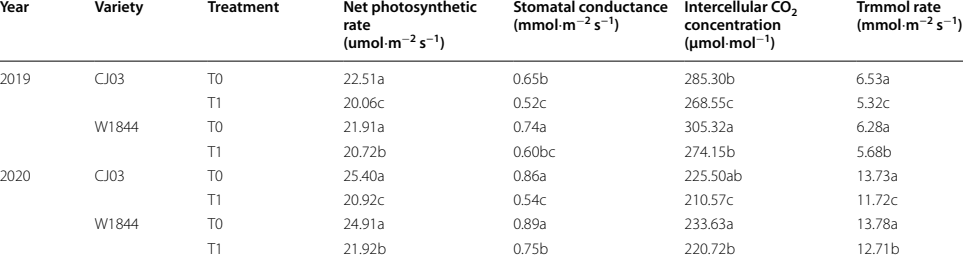

---

,IS,Inferior spikelets,Unnamed: 2,Unnamed: 3
0,SS,Superior spiklelets,,
1,OsSWEET11,Oryza sativa Sugar will,eventually be exported transporter,11
2,OsSUTs,Oryza sativa Sucrose,transporters,
3,SPS,Sucrose-phosphate,synthase,
4,SuSase,Sucrose synthase,,
5,AGPase,ADP-glucose,pyrophosphorylase,
6,T6P,Trehalose-6-phosphate,,
7,SnRK1,Snf1-related protein,kinase-1,
8,TPS,Trehalose-6-phosphate,synthase,
9,TPP,Trehalsoe-6-phosphate,phosphatase,

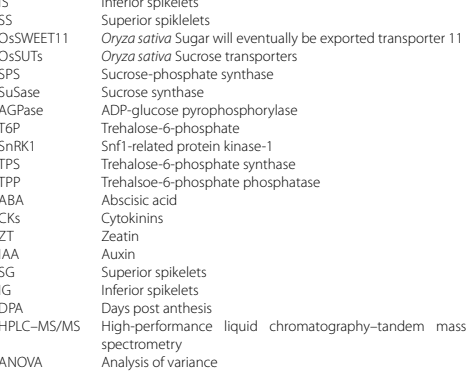

---

---

### 7.pdf

,Patient no,Genotype,Viral load (106 IU/ml),Sex,Age (years),Core amino acid \n70,Core amino acid \n91,rs12979860,End of treatment response a
0,R1,1a,4.36,M,52.6,R,C,CC,SVR
1,R2,1a,6.37,M,34.9,R,C,CC,SVR
2,R3,1a,7.84,M,45.8,R,C,CC,SVR
3,R4,1a,7.77,F,42.3,R,C,CC,SVR
4,R5,1a,7.05,M,45.3,R,C,CC,SVR
5,R6,1a,7.19,F,45.5,R,C,CC,SVR
6,R7,1a,5.54,F,46.9,R,C,CC,SVR
7,R8,1a,5.46,M,29.1,R,C,CT,SVR
8,R9,1a,6.18,M,50.7,R,C,CC,SVR
9,R10,1a,6.42,M,59.9,R,C,CC,SVR

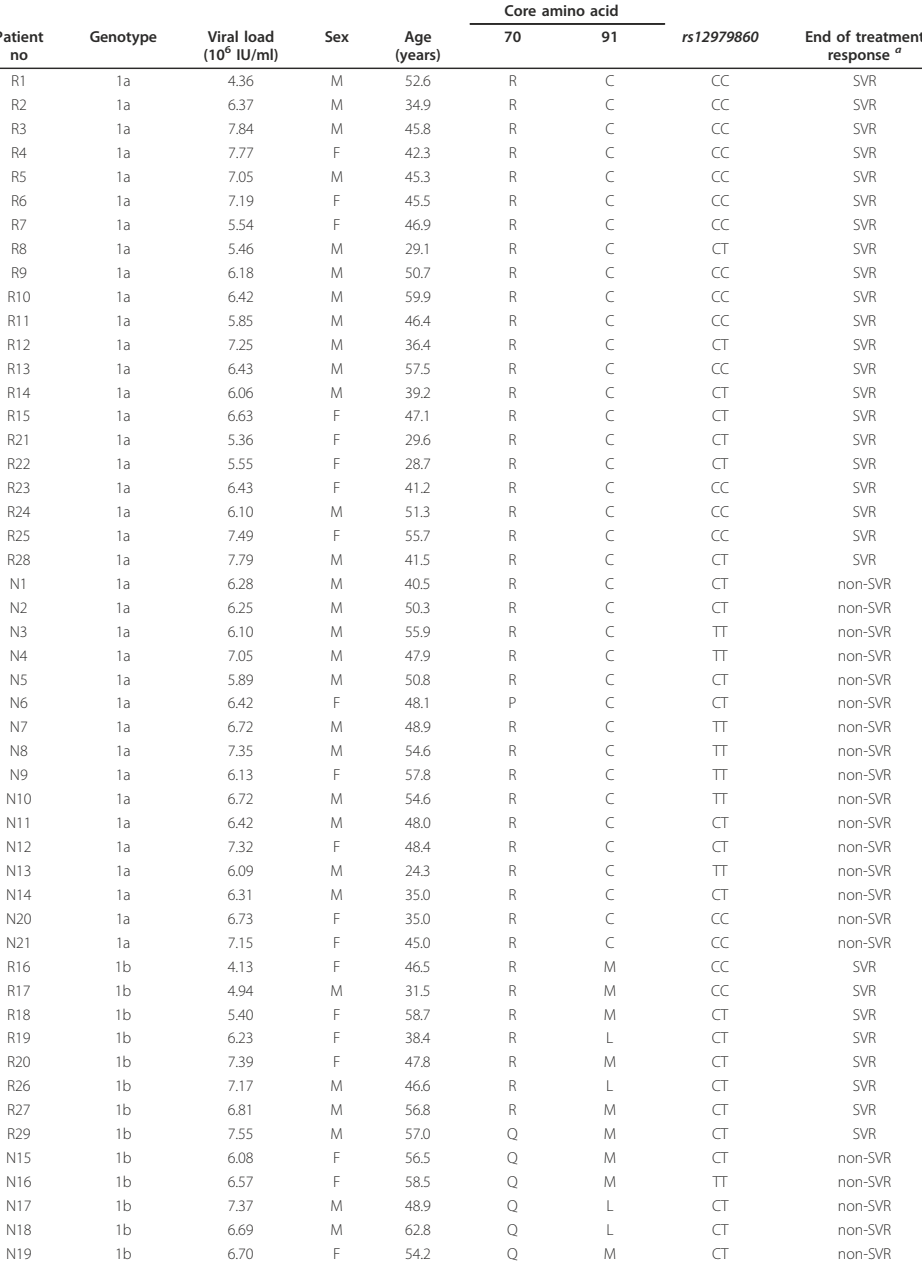

---

,Unnamed: 0,SVR n = 29,non-SVR n = 21,Univariate p value
0,Age (mean),45.2,48.8,0.09a
1,Number of patients < 45 / > 45 yrs,11 / 18,4 / 17,0.21b
2,Gender (m/f),17 / 12,13 / 8,1.0b
3,Baseline HCV RNA (mean log IU/mL),6.37,6.59,0.56a
4,Number with < 5.6 / > 5.6 log IU/mL,8 / 21,0 / 21,0.01b
5,Genotype 1a/1b,21 / 8,16 / 5,1.0b
6,Fibrosis (F0/F1/F2/F3/F4)c,0 / 10 / 13 / 4 / 0,2 / 4 / 4 / 7 / 2,0.19d
7,Core aa 70,28 R / 1 Q,15 R / 5 Q & 1 P,0.03b
8,Core aa 91,21 C / 6 M / 2 L,16 C / 3 M / 2 L,0.82e
9,rs12979860,16 CC / 13 CT / 0 TT,2 CC / 11 CT / 8 TT,0.0001e

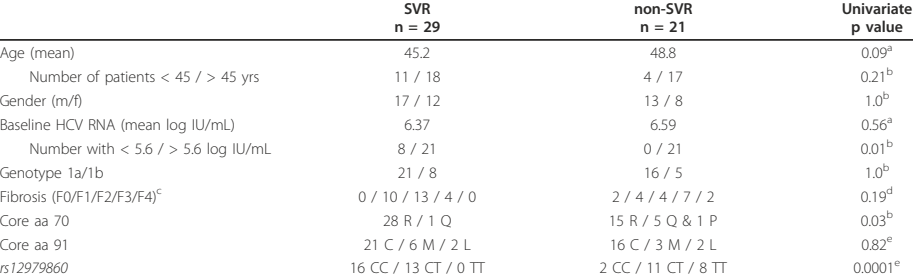

---

,Genotype,Amino acid 70 \nQ,Amino acid 70 \nR,Amino acid 70 \nP,Amino acid 70 \nH,Amino acid 91 \nC,Amino acid 91 \nM,Amino acid 91 \nL,Total
0,1a,2%,98%,-,-,100%,-,-,920
1,1b,60%,35%,-,4%,1%,71%,28%,2022
2,2,-,100%,-,-,39%,4%,58%,83
3,3,-,93%,6%,-,99%,-,-,204
4,4,5%,95%,-,-,100%,-,-,19
5,5,86%,14%,-,-,-,-,100%,14
6,6,60%,13%,13%,15%,100%,-,-,55

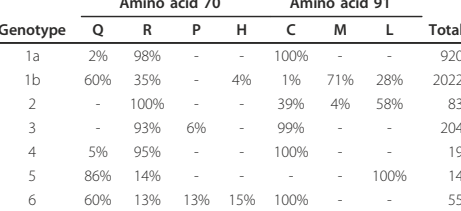

---

---

### 8.pdf

<ipython-input-27-8b660cb6aec7>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("",inplace=True)


,This work (ε3550 = 6.3 m2/mol),Peridotite,(K) 2173,Unnamed: 3,(bar−0.5) 2.91 × 10−3,(bar) 5.7 × 10−5 – 0.027,14
0,This work (ε3550 = 5.1 m2/mol),Peridotite,2173,,3.59 × 10−3,5.7 × 10−5 – 0.027,14
1,Newcombe et al. (2017),Anorthite-Diopside eutectic,1623,,4.22 × 10−3,9.8 × 10−3 – 0.32,14
2,Newcombe et al. (2017),Lunar Green Glass,1623,,4.04 × 10−3,9.8 × 10−3 – 0.32,11
3,Dixon et al. (1995),Mid-Ocean Ridge Basalt,1473,,5.36 × 10−3,17 – 709,14
4,Hamilton and Oxtoby (1986),NaAlSi3O8,1123 – 1573,,7.59 × 10−3 – 9.91 × 10−3,1685 – 2160,13

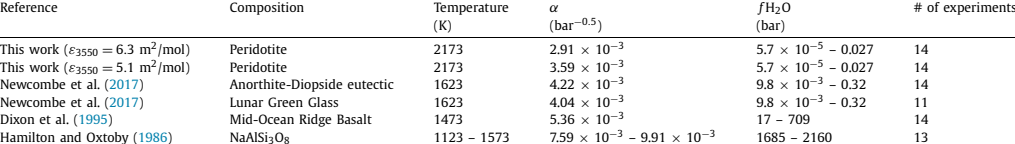

---

---

### false_positives.pdf

In [27]:
from IPython.display import display
from PIL import Image
import PIL
import pandas as pd
for subdir in sorted(os.listdir("results")):
    display(Markdown('---'))
    display(Markdown(f'### {subdir}.pdf'))
    for filename in sorted(os.listdir(f"results/{subdir}")):
        if filename.endswith(".png"):
            img = PIL.Image.open(f"results/{subdir}/{filename}")
            csv = filename[:-4] + ".csv"
            if os.path.exists(f"results/{subdir}/{csv}"):
                df = pd.read_csv(f"results/{subdir}/{csv}")
                df.fillna("",inplace=True)
                # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                if df is not None:
                    html = df.fillna("").to_html()
                else:
                    html = "table missing"
                display_html_and_image(html, img)
                display(Markdown('---'))

Strengths:
- alignment accuracy
- small and medium size tables
- throughput

Recent additions:
- rotated/vertical tables (v0.0.4)
- multi-indexes (v0.2)

Weaknesses:
- underlying OCR issues
- uneven columns, as in 4.pdf